## Descripción del proyecto
Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

### Instrucciones del proyecto
1. Descarga y prepara los datos.  Explica el procedimiento.

2. Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. Describe brevemente tus hallazgos.

3. Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.

4. Realiza la prueba final.

### Descripción de los datos
Cada observación en el dataset contiene información del comportamiento mensual sobre un usuario. La información dada es la siguiente:
Puedes encontrar los datos en el archivo  /datasets/Churn.csv file. Descarga el conjunto de datos.

Características:

- `Churn.csv`: cada fila corresponde a un pedido en la aplicación Instacart.
    - `'RowNumber'`: índice de cadena de datos
    - `'CustomerId'`: identificador de cliente único
    - `'Surname'`: apellido
    - `'CreditScore'`: valor de crédito
    - `'Geography'`: país de residencia
    - `'Gender'`: sexo
    - `'Age'`: edad
    - `'Tenure'`: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
    - `'Balance'`: saldo de la cuenta
    - `'NumOfProducts'`: número de productos bancarios utilizados por el cliente
    - `'HasCrCard'`: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
    - `'IsActiveMember'`: actividad del cliente (1 - sí; 0 - no)
    - `'EstimatedSalary'`: salario estimado

### Inicialización e importación de librerias 

### Cargar datasets

In [1]:
from sklearn.metrics import roc_auc_score # Calcular el AUC-ROC
from sklearn.metrics import roc_curve # Calcular la curva ROC
from sklearn.metrics import recall_score # Calcular Recall
from sklearn.metrics import precision_score # precision_score
from sklearn.metrics import accuracy_score 
from sklearn.utils import shuffle # Submuestreo
from sklearn.preprocessing import StandardScaler, MinMaxScaler # estandarizar los datos 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier # Ajuste de hiperparámetros # Bosque aleatorio
from sklearn.linear_model import LogisticRegression # Regresión Logistica
from sklearn.tree import DecisionTreeClassifier # Arbol de desiciones


from sklearn.model_selection import train_test_split # Separa los datos en entrenamiento, validación y uno de prueba
from sklearn.metrics import f1_score # Calcular valor F1

In [2]:
data = pd.read_csv('/datasets/Churn.csv') 

### Exploración inicial de datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Preprocesamiento de datos

Corrige el formato en los encabezados de la tabla de acuerdo con las reglas del buen estilo:
* Todos los caracteres deben ser minúsculas.
* Elimina los espacios.
* Si el nombre tiene varias palabras, utiliza snake_case.


In [4]:
data.shape # 14 filas 10000 datos

(10000, 14)

In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


- El target que queremos predecir el de la columna "Exited", no queremos considerar las columnas "row_number", "customerid" y "surname" ya que solo aportan valores únicos del tipo de datos string y no son de importancia para el analisis. 
- Para el analisis crearemos nuevas columnas binarias que nos ayudaran para realizar el analisis.

In [6]:
# Tenemos solo 2 caracteristicas de valores, para el analisis lo transformaremos a binario
data["Gender"].value_counts() 

Male      5457
Female    4543
Name: Gender, dtype: int64

In [7]:
# Verificamos los valores para el analisis lo transformaremos a binario
data["Geography"].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [8]:
# Codificamos solo 2 valores para la columna gender
data["gender_male"] = (data["Gender"] == "Male").astype("int")

# Codificamos solo 2 valores para la columna geography
# tenemos que construir 3 categorias -1 ya que la 3 categoria queda implicita.
data["geopgraphy_france"] = (data["Geography"] == "France").astype("int")
data["geopgraphy_germany"] = (data["Geography"] == "Germany").astype("int")

- Conclusión, creamos 3 columnas nuevas "gender_male", "geopgraphy_france", "geopgraphy_germany" para realizar nuestro analisis. Siempre construimos 1 columna menos del total de caterorias, ya que la ultima columna tendria un valor implicito. 
- En este caso queda por defecto la categoria "spain", evitamos crear inconsistencias en el modelo.

## Prepara los datos
### Convierte los datos en los tipos necesarios.
- Verifica y corrige los tipos de datos con dtype() 
- Identifica y completa valores ausentes con isna() sum()
- Identifica y elimina los valores duplicados duplicated()  

In [9]:
type(data)

# Identificamos tipos de datos
data.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                float64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
gender_male             int64
geopgraphy_france       int64
geopgraphy_germany      int64
dtype: object

In [10]:
# Buscamos valores ausentes y los sumamos
data.isna().sum()

RowNumber               0
CustomerId              0
Surname                 0
CreditScore             0
Geography               0
Gender                  0
Age                     0
Tenure                909
Balance                 0
NumOfProducts           0
HasCrCard               0
IsActiveMember          0
EstimatedSalary         0
Exited                  0
gender_male             0
geopgraphy_france       0
geopgraphy_germany      0
dtype: int64

In [11]:
data["Tenure"].value_counts(dropna=False).sort_index()

# utilizamos sort_index para ordenar ascendiente
# Encontramos 909 valores nulos 

0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
NaN     909
Name: Tenure, dtype: int64

In [12]:
# Remplazamos los valores ausentes con un valor -1
# Podriamos probar remplazar con otro valor diferente de -1 para realzar comparaciones

data["Tenure"].fillna(-1, inplace=True)

In [13]:
# Verificamos que no existan valores ausentes
data.isna().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
gender_male           0
geopgraphy_france     0
geopgraphy_germany    0
dtype: int64

In [14]:
# Contar duplicados explícitos
data.duplicated().sum()

0

In [15]:
data.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,gender_male,geopgraphy_france,geopgraphy_germany
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0,1,0
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0,0,0


In [16]:
target = 'Exited'

In [17]:
# Calculamos la proporción de esas filas que tienen un valor igual a 1 dentro de la clase positiva
# calculamos el promedio 0.2 clase positiva
data["Exited"].mean()

0.2037

In [18]:
# Calculamos la proporción de esas filas que tienen un valor igual a 1 dentro de la clase negativa
# calculamos el promedio 0.79 clase negativa
1 - data["Exited"].mean()
# Valor 0.7963

0.7963

In [19]:
target = 'Exited'
exclude_columns = ["RowNumber", "CustomerId", "Surname", "Geography", "Gender", target]
features = [c for c in data.columns if c not in exclude_columns]

## Analiza los datos
### Instrucciones del proyecto
- Segmenta los datos fuente en un conjunto de entrenamiento, uno de validación y uno de prueba.

In [20]:
# Separa los datos en entrenamiento, validación y uno de prueba
full_train_df, test_df = train_test_split(
    data, 
    test_size=0.18, 
    random_state=88)

train_df, valid_df = train_test_split(
    full_train_df, 
    test_size=0.23, 
    random_state=100)

In [21]:
# Aplicamos len la cantidad de filas para cada una de las tablas entre[]
[len(df) for df in [data, full_train_df, train_df, valid_df, test_df]]

[10000, 8200, 6314, 1886, 1800]

In [22]:
# Verificamos que porcentaje estamos utilizando de la muestra
[round(len(df) / len(data), 4) for df in [data, full_train_df, train_df, valid_df, test_df]]

[1.0, 0.82, 0.6314, 0.1886, 0.18]

Conclusiones, 
- Consideramos trabajar con un porcentanje cercano al 65/ 20 / 15 para obtener una cantidad suficiente de datos para cada segmento. 
- Consideramos dividir en 4 grupos la proporcion del 100% de la tabla, para lo cual logramos lo siguiente: 
- full_train_df 0.631 es decir 63.1% de los datos, valid_df validar los datos con el 18.86% y el es test_df con el 18%

### Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. Describe brevemente tus hallazgos.

### Ajuste de hiperparámetros - Regresión logística

In [23]:
# llamamos al modelo de regresión logistica

lr_model = LogisticRegression(random_state=54321, solver='liblinear')# inicializa el constructor de regresión logística con los parámetros 
lr_model.fit(train_df[features], train_df[target]) # entrena el modelo en el conjunto de entrenamiento

y_preds = lr_model.predict_proba(test_df[features])[:, 1]

In [24]:
score_train = lr_model.score(train_df[features], train_df[target]) # calcula la puntuación de accuracy en el conjunto de entrenamiento
score_valid = lr_model.score(valid_df[features],valid_df[target]) # calcula la puntuación de accuracy en el conjunto de validación

print("Accuracy del modelo de regresión logística en el conjunto de entrenamiento:", score_train)
print("Accuracy del modelo de regresión logística en el conjunto de validación:", score_valid)

Accuracy del modelo de regresión logística en el conjunto de entrenamiento: 0.7923661704149509
Accuracy del modelo de regresión logística en el conjunto de validación: 0.7889713679745494


# Valor F1
Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

In [25]:
full_train_df, test_df = train_test_split(data[features + [target]], test_size=0.2, random_state=88)

train_df, valid_df = train_test_split(full_train_df, test_size=0.2, random_state=888)

In [26]:
# Estandarizar los datos 
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

# columnas que queremos escalar corresponden a variables numericas
columns_to_scale = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]

# Solamennte utilizar el train_df, para entrenar el scale solamente para las columnas que quiero escalar 
scaler.fit(train_df[columns_to_scale])

# Muestra de entrenamiento
train_df_scaled = train_df.copy() # realizamos una copia 
train_df_scaled[columns_to_scale] = scaler.transform(train_df_scaled[columns_to_scale])

# Muestra de validación
valid_df_scaled = valid_df.copy()
valid_df_scaled[columns_to_scale] = scaler.transform(valid_df_scaled[columns_to_scale])

# Muestra de prueba solo para el metodo transform 
test_df_scaled = test_df.copy()
test_df_scaled[columns_to_scale] = scaler.transform(test_df_scaled[columns_to_scale])

In [27]:
# Ajuste del umbral

thresholds = []
f1_scores = []
best_threshold = -1
best_score = -float("inf")

y_valid_preds = lr_model.predict_proba(valid_df[features])[:, 1] # Definimos la variable 

for t in np.linspace(0, 0.4, 21):
    y_preds_class = y_valid_preds > t
    
    thresholds.append(t)
    f1_score_result = f1_score(valid_df[target], y_preds_class)
    
    f1_scores.append(f1_score_result)
    
    if f1_score_result > best_score:
        best_score = f1_score_result
        best_threshold = t
    
evaluations = pd.DataFrame(data={
    "threshold": thresholds,
    "f1_score": f1_scores
})

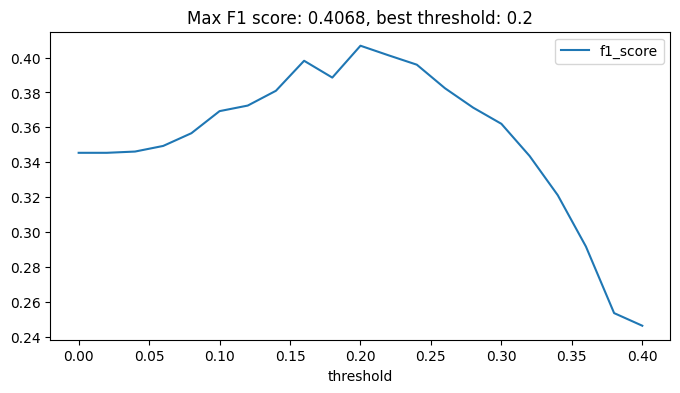

In [28]:
plt.figure(figsize=(8, 4))
plt.title(f"Max F1 score: {round(best_score, 4)}, best threshold: {best_threshold}")
evaluations.plot(kind="line", x="threshold", y="f1_score", ax=plt.gca())
plt.show()

- Segun los datos analizados el 20% corresponde a la clase positiva y el 80% a la clase negativa. Cualquier valor diferente al 50% del promedio se considera desequilibrio. 
- El problema que mas afecta al F1 que elegimos es el valor del umbral que elegimos. F1 score: 0.40
- La curva demuestra que decrese drasticamente a 0
- El "best_threshold" es de 0.2

In [29]:
# Entrenamiento de clase 
class_weights = [4, 4.5, 5, 5.5, 6]

best_final_class_weight = 0
best_final_score = -float("inf")
best_final_threshod = -1

for class_weight in class_weights:

    lr_model = LogisticRegression(class_weight={0: 1, 1: class_weight})
    lr_model.fit(train_df_scaled[features], train_df_scaled[target])

    y_valid_preds = lr_model.predict_proba(valid_df_scaled[features])[:, 1]

    thresholds = []
    f1_scores = []
    best_threshold = -1
    best_score = -float("inf")

    for t in np.linspace(0, 1, 21):
        y_preds_class = y_valid_preds > t

        thresholds.append(t)
        f1_score_result = f1_score(valid_df[target], y_preds_class)

        f1_scores.append(f1_score_result)

        if f1_score_result > best_score:
            best_score = f1_score_result
            best_threshold = t

    if best_score > best_final_score:
        best_final_score = best_score
        best_final_threshod = best_threshold
        best_final_class_weight = class_weight
        
print('best final score:', best_final_class_weight)
print('best final class weight:', best_final_class_weight)
print('best_final_threshod:', best_final_threshod)

best final score: 5.5
best final class weight: 5.5
best_final_threshod: 0.65


In [30]:
# Entrenamos con el mejor "best_final_class_weight"

full_train_df_scaled = full_train_df.copy()
full_train_df_scaled[columns_to_scale] = scaler.transform(full_train_df_scaled[columns_to_scale])

final_lr_model = LogisticRegression(class_weight={0:1, 1: best_final_class_weight})
final_lr_model.fit(full_train_df_scaled[features], full_train_df_scaled[target])

y_test_preds = final_lr_model.predict_proba(test_df_scaled[features])[:, 1]
y_test_class_preds = y_test_preds > best_final_threshod

final_f1_score_result = f1_score(test_df[target], y_test_class_preds)
print(final_f1_score_result)

0.4811416921508665


- Conclusión con el entrenamiento de LogisticRegression y la mejora de clases logramos el resultado de 0.48 no es el mejor modelo de entrenamiento probaremos con otro modelo. 

In [31]:
# Actualización del modelo de entrenamiento 

target = data['Exited']
features = data.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

## Sobremuestreo

In [32]:
features_zeros = features_train[target_train == 0] 
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)


(5998, 16)
(1502, 16)
(5998,)
(1502,)


- Conlcusión, Las observaciones positivas son escasas en comparación con las negativas, por lo que debemos mantener el pensamiento positivo y el sobremuestreo. 
- Esta técnica ayuda al modelo a reconocer y clasificar mejor las instancias de clase minoritaria, lo que finalmente aumenta nuestro valor F1.

In [33]:
repeat = 5
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

print(features_upsampled.shape)
print(target_upsampled.shape)

(13508, 16)
(13508,)


In [34]:
# Verificamos el cambio en el promedio del target 
print(target_train.mean(), target_upsampled.mean())

0.20026666666666668 0.5559668344684632


- Conclusión 
- Utilizamos un valor más bajo de repeat = 5
- Para que el imbalance pasa de 0.20 (imbalanceado) y el queda target_upsampled en 0.55 (balanceado pues es cercano al 0.5).

### Submuestreo

In [35]:
def downsample(features, target, fraction): # pásale tres argumentos 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
# # Sample  para eliminar aleatoriamente una proporción de las observaciones 
#de la clase predominante (negativa en este caso)
    features_downsampled = pd.concat( 
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25
)

print(features_downsampled.shape)
print(target_downsampled.shape)

(3002, 16)
(3002,)


In [36]:
# Verificamos el cambio en el promedio del target 
print(target_train.mean(), target_downsampled.mean())

0.20026666666666668 0.5003331112591606


- Conclusión 
- Utilizamos un valor target_train, 0.25
- Para que el imbalance pasa de 0.20 (imbalanceado) y el queda target_upsampled en 0.50 (balanceado pues es cercano al 0.5).

### Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.

### Ajuste de hiperparámetros -  Bosque aleatorio

In [37]:
target.astype("boolean").value_counts()

False    7963
True     2037
Name: Exited, dtype: Int64

In [38]:
features

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,gender_male,geopgraphy_france,geopgraphy_germany
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,0,1,0
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,0,1,0
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,1,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,1,1,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,1,1,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,0,1,0
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1,0,1


In [39]:
# Entrena a tu segundo modelo RandomForestClassifier
model =  RandomForestClassifier(n_estimators=100, random_state=100)

feature_names = features = [c for c in data.columns if c not in exclude_columns]
target_name = 'Exited'

model.fit(train_df[feature_names], train_df[target_name])
y_preds = model.predict(test_df[feature_names])

accuracy_score(test_df[target_name], y_preds)

0.854

In [40]:
max_score = -100

for n_estims in [50, 100, 150, 200]:
    for max_d in [5, 10, 15]:
    
        model = RandomForestClassifier(n_estimators=n_estims, max_depth=max_d, random_state=100)
    
        model.fit(train_df[feature_names], train_df[target_name])
        y_preds = model.predict(test_df[feature_names])
    
        score = accuracy_score(test_df[target_name], y_preds)
        
        if score > max_score:
            max_score = score
            print(f"""
            N estimator: {n_estims}
            Max depth: {max_d}
            Accuracy: {score}       
            """)


            N estimator: 50
            Max depth: 5
            Accuracy: 0.842       
            

            N estimator: 50
            Max depth: 10
            Accuracy: 0.854       
            

            N estimator: 100
            Max depth: 10
            Accuracy: 0.8545       
            

            N estimator: 100
            Max depth: 15
            Accuracy: 0.8565       
            

            N estimator: 150
            Max depth: 10
            Accuracy: 0.8575       
            

            N estimator: 150
            Max depth: 15
            Accuracy: 0.859       
            


- Conclusión,
- Podemos encontrar la mejor combinación. En este caso la que alcanzo el mejor desempeño es   
            - N estimator: 50
            - Max depth: 5
            - Accuracy: 0.8395     

## Realiza la prueba final.

### AUC-ROC 
Además, debes medir la métrica AUC-ROC y compararla con el valor F1

In [41]:
# Separa los datos en entrenamiento y validación 
train, valid = train_test_split(data, test_size=0.25, random_state=12345)

In [42]:
# Declara cuatro variables y almacena las características y el objetivo de la siguiente manera:

features_train = train.drop('Exited', axis=1)
target_train = train['Exited']

features_valid = valid.drop('Exited', axis=1)
target_valid = valid['Exited']


print(features_train.shape)
print(features_valid.shape)

(7500, 16)
(2500, 16)


In [43]:
#Entrenamiento de pilotos
#Para predecir la clase, necesitamos a nuestra vieja amiga, la regresión logística.

data = pd.read_csv('/datasets/Churn.csv') 

print(data.dtypes) # <  termina el código>)
print(data['Exited'].head(5)) # <  termina el código >)

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64


In [44]:
# Codificación One-Hot
import pandas as pd

data = pd.read_csv('/datasets/Churn.csv') 

print(pd.get_dummies(data["Exited"]).head(5))

   0  1
0  0  1
1  1  0
2  0  1
3  1  0
4  1  0


Conclusión, se necesitan dos dummies para encontrar dos valores caracteristicos.

### Conclusión
Podemos encontrar la mejor combinación para enconfrar el valor F1 En este caso la que alcanzo el mejor desempeño es   
- N estimator: 50
- Max depth: 5
- Accuracy: 0.8395    
            
Obtuvimos los resultados para:            
best final score: 5.5
best final class weight: 5.5
best_final_threshod: 0.65
            